In [ ]:
# for now, just request a random composite spectrum from facula_and_spot_creator
# and try to decompose it - aka can we regenerate the w's

# eventually can read in external data or some training data from a large hdf5 file etc

from itertools import product
from pathlib import Path
import astropy
from astropy.table import QTable
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy as sp
from astropy.visualization import quantity_support
quantity_support()
from tqdm import tqdm
import astropy.units as u
from scipy.interpolate import interp1d
from astropy.units import Quantity
from joblib import Parallel, delayed
import os

from spots_and_faculae_model.spectrum import spectrum
from spots_and_faculae_model.readers import read_JWST_fits
from spots_and_faculae_model.simpler_spectral_grid import simpler_spectral_grid

external_spectrum_path = Path("../../assets/MAST_2025-10-26T11_57_04.058Z - LTT/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg001_nis_x1dints.fits")
script_dir = os.getcwd()  # usually the folder where notebook is running")
wavelength_grid_absolute_path = (script_dir / external_spectrum_path).resolve()

spectrum_to_decompose : spectrum = read_JWST_fits(wavelength_grid_absolute_path)

print(spectrum_to_decompose)

mask = np.isfinite(spectrum_to_decompose.Fluxes)

spectrum_to_decompose = spectrum_to_decompose[mask]

print("reading in hdf5")
spectral_grid_relative_path = Path("../../assets/new_spectral_grid.hdf5")
spectral_grid_absolute_path = (script_dir / spectral_grid_relative_path).resolve()
spec_grid : simpler_spectral_grid = simpler_spectral_grid.from_hdf5(absolute_path=spectral_grid_absolute_path)
lookup_table = spec_grid.to_lookup_table()
print("finished reading in hdf5")

print(lookup_table[2500 *u.K, 0.0 * u.dimensionless_unscaled, 0.0 * u.dimensionless_unscaled])

In [2]:
from typing import Sequence, Tuple
from scipy.optimize._optimize import OptimizeResult

def calc_result(parameter_space, total_number_of_components : int = None, verbose : bool = True) -> Tuple[np.ndarray, OptimizeResult]:
    A = np.empty((0, 0))

    def force_to_janskys(T_eff : Quantity, FeH : Quantity, log_g : Quantity, wavelengths : Sequence[Quantity], mask):
        fluxes = lookup_table[T_eff, FeH, log_g]
        return fluxes.to(u.Jy, equivalencies=u.spectral_density(wavelengths))[mask]

    normalised_and_converted_spectral_components : list[list[Quantity]] = Parallel(n_jobs=-1, prefer="threads")(
        delayed(force_to_janskys)(T_eff, FeH, log_g, spec_grid.Wavelengths, mask) for T_eff, FeH, log_g in tqdm(parameter_space, total=total_number_of_components, desc="Appending values to A matrix...", disable=not verbose)
    )

    A = np.column_stack(normalised_and_converted_spectral_components)

    if verbose:
        print("minimising")
    
    # assume that w \in [0,1] : but I think this will only be true for real data if normalisation has been done correctly (???)
    result : OptimizeResult = sp.optimize.lsq_linear(A, [i.value for i in spectrum_to_decompose.Fluxes], bounds = (0, 1), verbose = 2 if verbose else 0)#, max_iter=2), tol=1e-10, lsmr_tol=1e-5)
    
    if verbose:
        print(result)
        print(f"sum of weights={np.sum(result.x)}")

    return A, result

all_parameters = list(product(spec_grid.T_effs, spec_grid.FeHs, spec_grid.Log_gs))

total_number_of_components = len(spec_grid.T_effs) * len(spec_grid.FeHs) * len(spec_grid.Log_gs)

A, result = calc_result(all_parameters, total_number_of_components)

      19         1.8573e+00      4.56e-04       4.07e-04       7.94e-01    
      20         1.8567e+00      6.13e-04       1.55e-04       1.29e-02    
      21         1.5647e+00      2.92e-01       6.58e-03       3.18e+00    
      22         1.5641e+00      5.62e-04       3.84e-04       3.10e+00    
      23         1.5633e+00      7.93e-04       8.79e-04       2.56e+00    
      24         1.5629e+00      4.45e-04       4.66e-04       1.12e+00    
      25         1.5626e+00      2.57e-04       2.10e-04       3.47e-01    
      26         1.5577e+00      4.94e-03       6.05e-04       7.23e+00    
      27         1.5560e+00      1.72e-03       2.85e-05       2.93e+00    
      28         1.5558e+00      1.40e-04       1.52e-05       1.68e+00    
      29         1.5549e+00      9.14e-04       8.17e-04       1.50e+00    
      30         1.5543e+00      6.22e-04       7.62e-04       3.80e-03    
      31         1.2910e+00      2.63e-01       1.90e-02       7.76e-01    
      32    

/tmp/ipykernel_230356/748890357.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)


     T_eff / K Fe/H / relative to solar log_g / log(cm s^(-2))  weight
1624  3600.0 K                      0.5                    6.0   0.386
2053  4000.0 K                     -1.0                    6.0   0.198
1164  3200.0 K                      1.0                    3.5   0.102
1611  3600.0 K                      0.0                    6.0   0.096
2014  4000.0 K                     -3.0                    6.0   0.062
301   2500.0 K                     -0.5                    1.0   0.059
425   2600.0 K                     -0.5                    4.5   0.045
1989  4000.0 K                     -4.0                    0.0   0.014
67    2300.0 K                     -0.5                    1.0   0.009
1403  3400.0 K                      1.0                    6.0   0.007


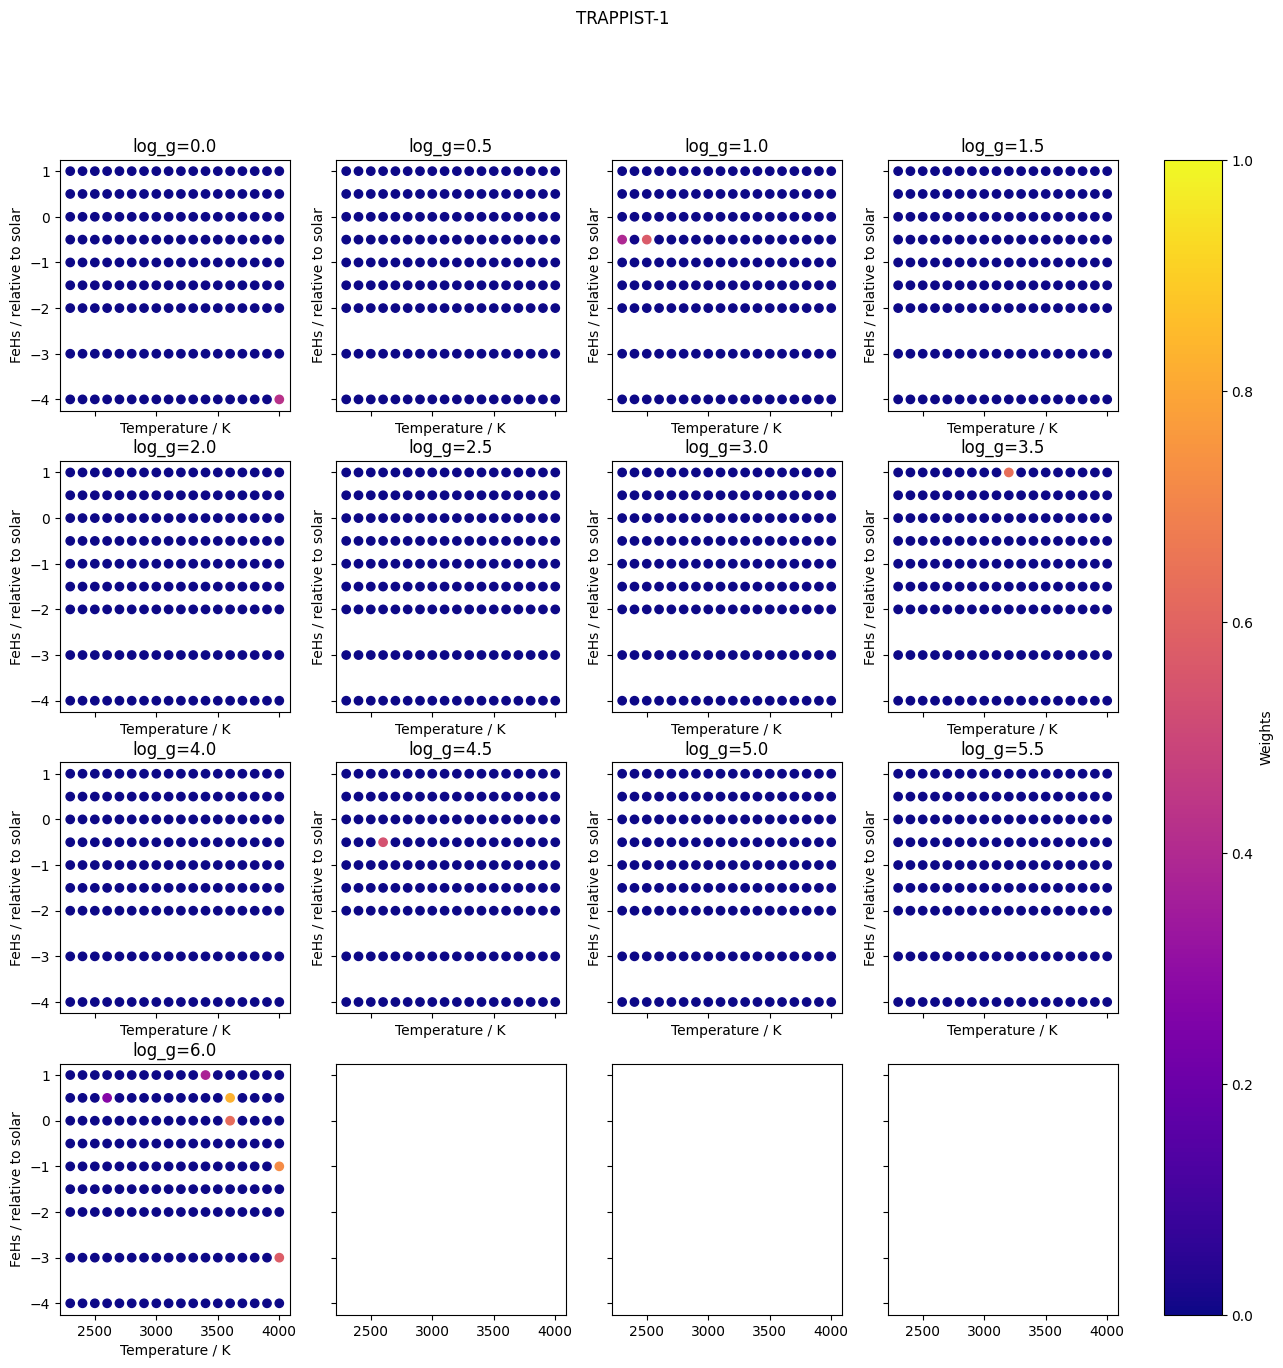

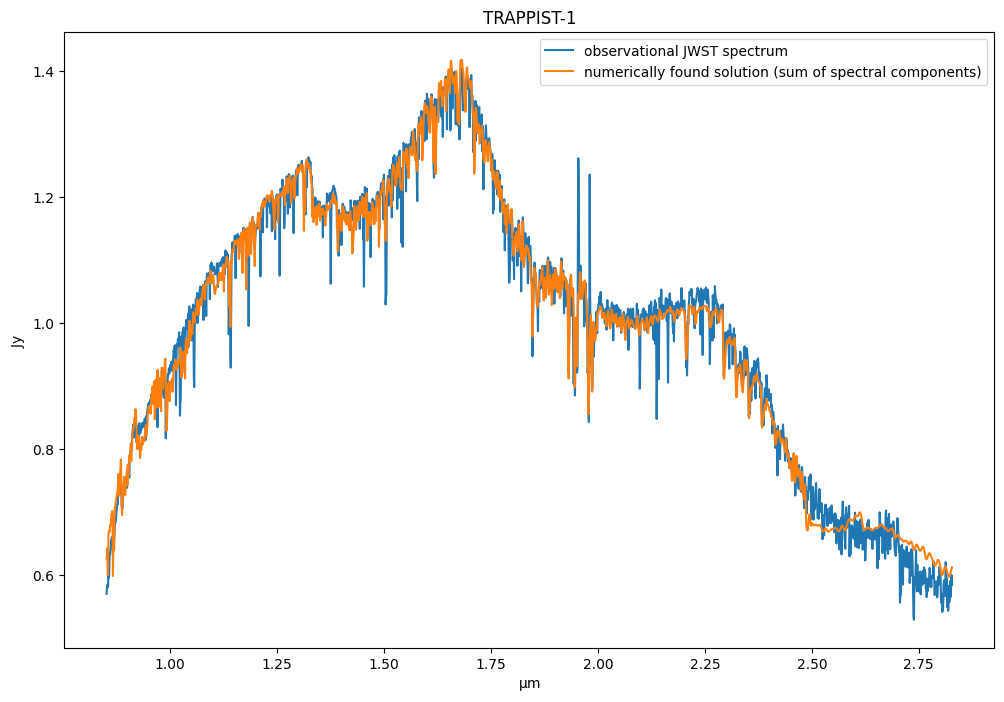

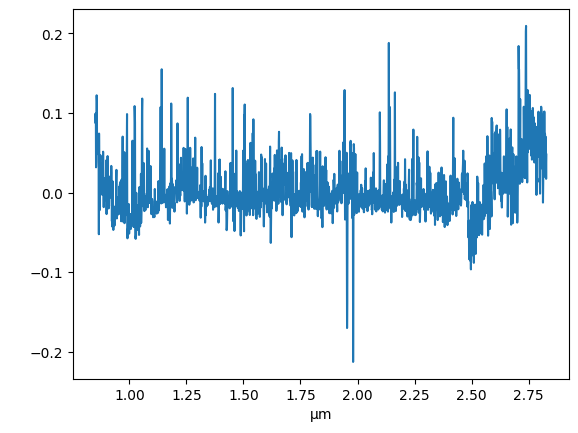

In [3]:

# # # plot some data # # #
# dependent on the old spectrum_grid class, but its fine for now (and its just dependent on some arbitrary strings anyway)
from spots_and_faculae_model.spectrum_grid import TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN
WEIGHT_COLUMN : str = "weight"

def plot_nicely(A, result, parameter_space):
    result_map = {}
    i = 0
    for (T_eff, FeH, log_g) in parameter_space:
        key = (T_eff, FeH, log_g)
        result_map[key] = i
        i += 1

    hash_map = pd.DataFrame(columns=[TEFF_COLUMN, FEH_COLUMN, LOGG_COLUMN, WEIGHT_COLUMN])
    
    for (T_eff, FeH, log_g) in parameter_space:
        new_row = {TEFF_COLUMN: T_eff, FEH_COLUMN: FeH, LOGG_COLUMN: log_g, WEIGHT_COLUMN: result.x[result_map[(T_eff, FeH, log_g)]]}
        hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)

    print(hash_map.sort_values(WEIGHT_COLUMN, ascending=False).head(10).round(3))

    fig, axes = plt.subplots(4, 4, figsize=(15, 15), sharex=True, sharey=True)
    axes = axes.ravel()
    for i, log_g in enumerate(spec_grid.Log_gs):
        subset = hash_map[hash_map[LOGG_COLUMN] == log_g]
        x_vals = [a.value for a in subset[TEFF_COLUMN]]
        y_vals = subset[FEH_COLUMN]
        z_vals = subset[WEIGHT_COLUMN]

        sc = axes[i].scatter(x_vals, y_vals, c=z_vals**.2, cmap='plasma', vmin=0, vmax=1)

        axes[i].set_title(f"log_g={log_g}")
        axes[i].set_xlabel("Temperature / K")
        axes[i].set_ylabel("FeHs / relative to solar")
        # axes[i].set_xticks(np.arange(np.min(T_effs) / u.K, np.max(T_effs) / u.K + 1, 50) * u.K)
        # axes[i].grid()

    STAR_NAME : str = "TRAPPIST-1"
    cbar = fig.colorbar(sc, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)
    cbar.set_label("Weights")
    fig.suptitle(STAR_NAME)
    plt.show()

    plt.figure(figsize=(12,8))
    plt.title(STAR_NAME)
    
    determined_spectrum = spectrum(spectrum_to_decompose.Wavelengths, A @ result.x)
    plt.plot(spectrum_to_decompose.Wavelengths, spectrum_to_decompose.Fluxes, label="observational JWST spectrum")
    plt.plot(determined_spectrum.Wavelengths, determined_spectrum.Fluxes, label="numerically found solution (sum of spectral components)")

    plt.legend()
    plt.show()

    residual = (determined_spectrum.Fluxes - spectrum_to_decompose.Fluxes) / spectrum_to_decompose.Fluxes
    plt.clf()
    plt.plot(spectrum_to_decompose.Wavelengths, residual)
    plt.show()

    return hash_map

hash_map = plot_nicely(A, result, all_parameters)

100%|██████████| 29/29 [00:08<00:00,  3.33it/s]


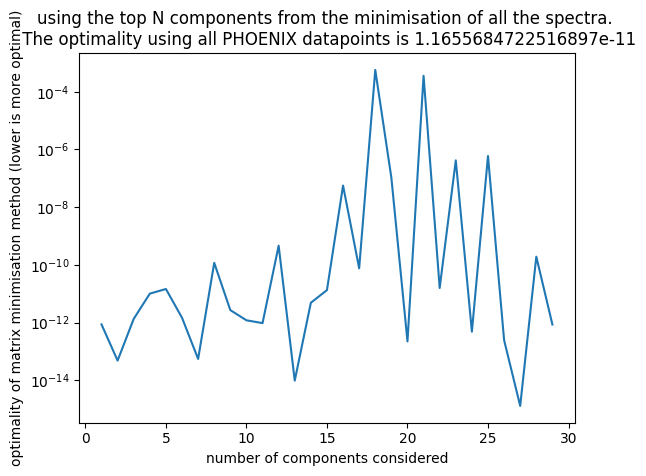

In [8]:
# now lets re-run that, but with only the top few components and see if the fit is better

# prolly want a new class for this lmao
# or could be a list of phoenix spectra; maybe that would help the above code be a bit neater too
main_components : list[(Quantity, Quantity, Quantity)] = []

ns = range(1, 30)
optimalities = []

for number_of_components_to_keep in tqdm(ns):

    for index, row in hash_map.sort_values(WEIGHT_COLUMN, ascending=False)[0:number_of_components_to_keep].iterrows():
        main_components.append((row[TEFF_COLUMN], row[FEH_COLUMN], row[LOGG_COLUMN]))

    A_restricted, result_restricted = calc_result(main_components, len(main_components), verbose=False)

    optimalities.append(result_restricted.optimality)

plt.clf()
plt.semilogy(ns, optimalities)
plt.xlabel("number of components considered")
plt.ylabel("optimality of matrix minimisation method (lower is more optimal)")
plt.title(f"using the top N components from the minimisation of all the spectra. \n The optimality using all PHOENIX datapoints is {result.optimality}")
plt.show()

/tmp/ipykernel_230356/748890357.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)


    T_eff / K Fe/H / relative to solar log_g / log(cm s^(-2))  weight
406  3600.0 K                      0.5                    6.0   0.014
378  3600.0 K                      0.5                    6.0   0.014
28   3600.0 K                      0.5                    6.0   0.014
21   3600.0 K                      0.5                    6.0   0.014
253  3600.0 K                      0.5                    6.0   0.014
300  3600.0 K                      0.5                    6.0   0.014
276  3600.0 K                      0.5                    6.0   0.014
325  3600.0 K                      0.5                    6.0   0.014
351  3600.0 K                      0.5                    6.0   0.014
36   3600.0 K                      0.5                    6.0   0.014


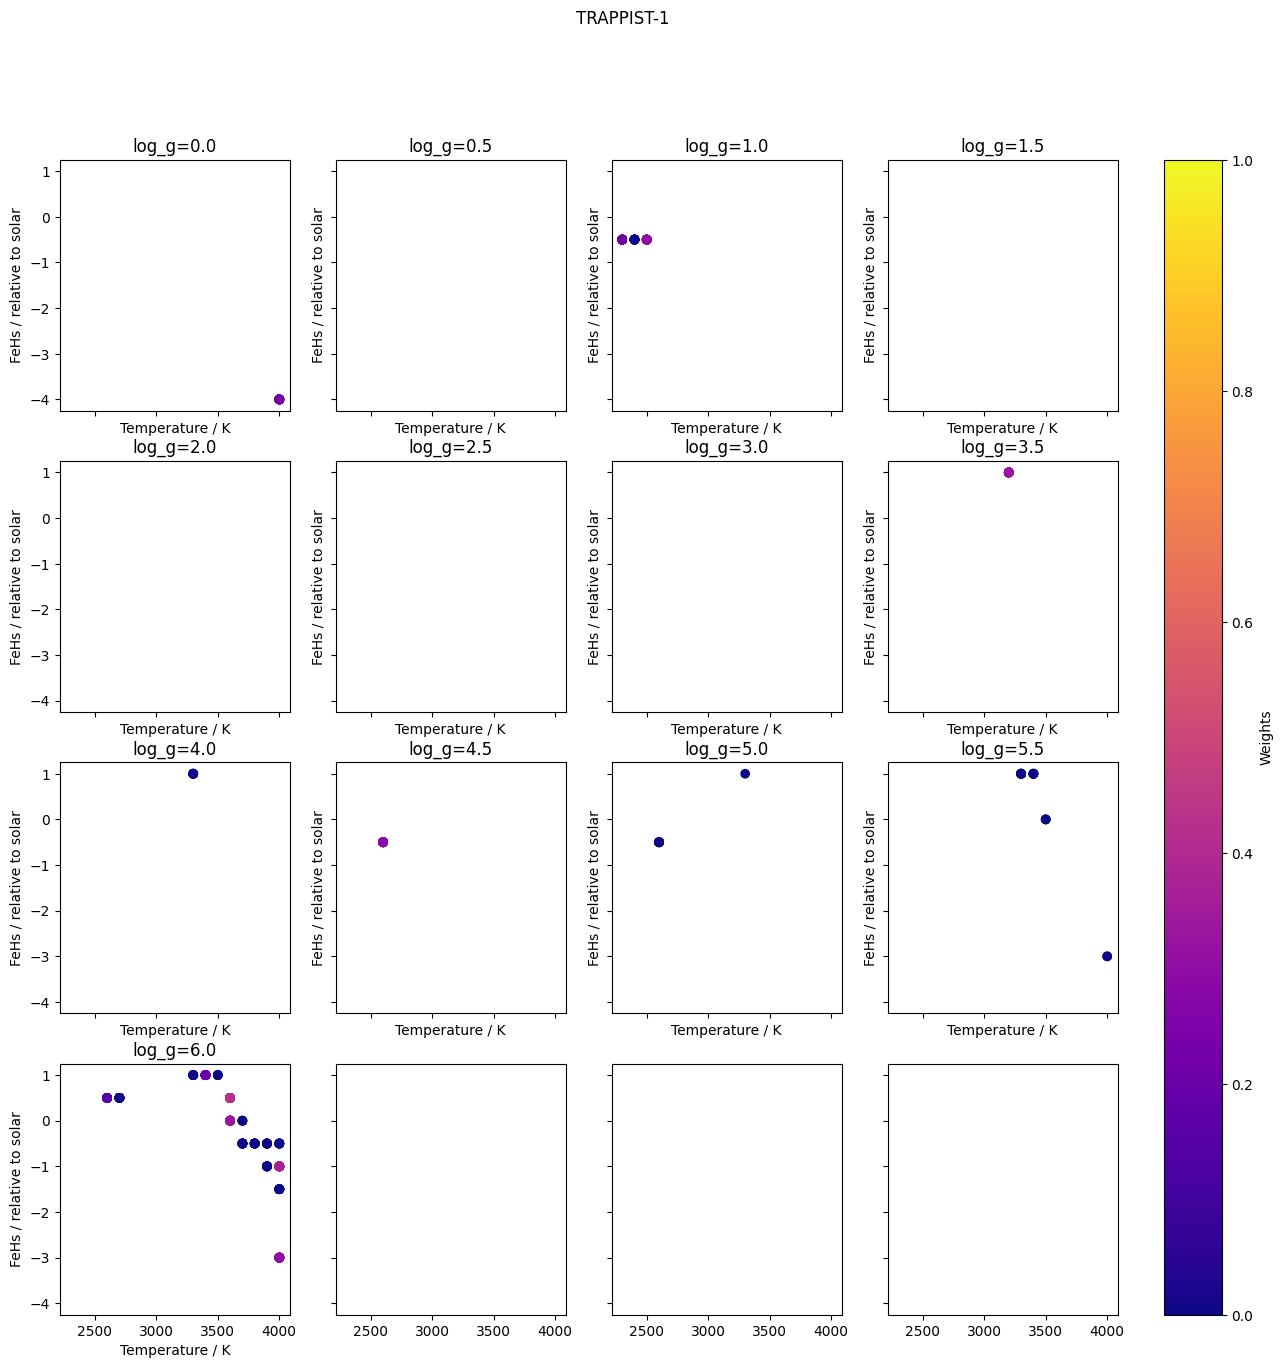

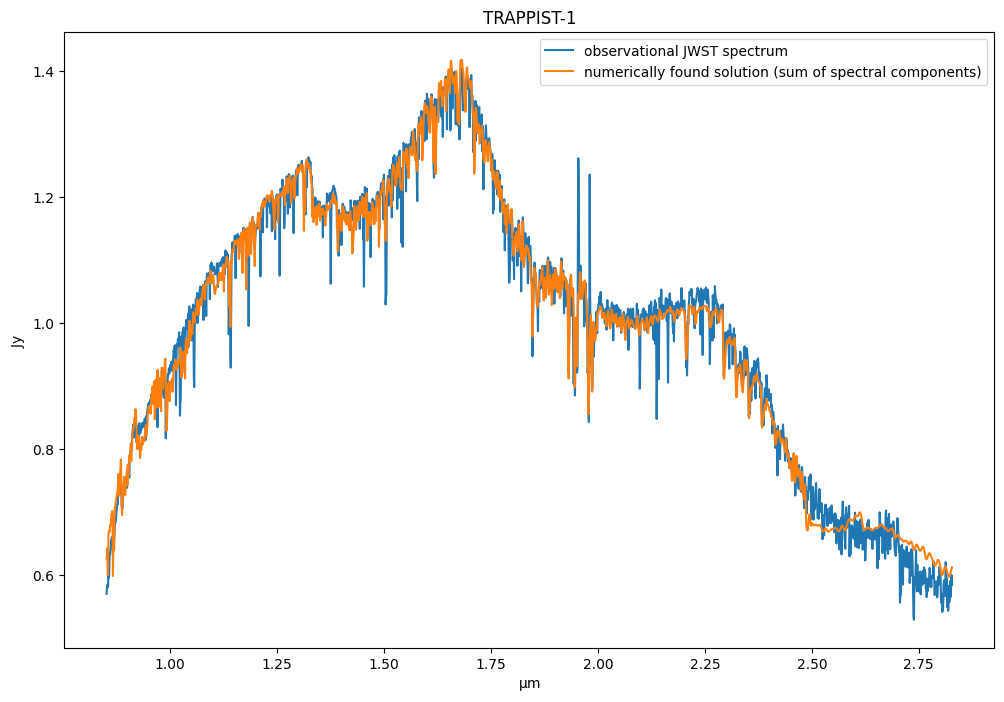

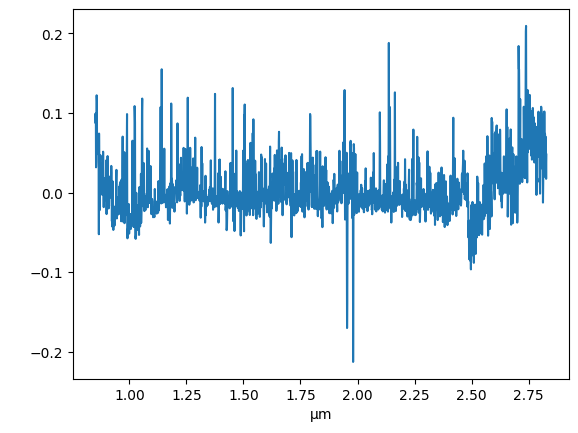

In [7]:
_ = plot_nicely(A_restricted, result_restricted, main_components)